# `Fine-Tuning mT5_multilingual_XLSum`


In [1]:
MODEL_NAME = 'csebuetnlp/mT5_multilingual_XLSum'

In [2]:
# %pip install peft

# %pip install -q -U bitsandbytes
# %pip install -q -U git+https://github.com/huggingface/transformers.git
# %pip install -q -U git+https://github.com/huggingface/peft.git
# %pip install -q -U git+https://github.com/huggingface/accelerate.git
# %pip install -q datasets

# %pip install rouge_score

In [3]:
import pandas as pd
import datasets
import torch

from tqdm import tqdm
import re

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, SummarizationPipeline

/users/eleves-a/2021/abasse.dabere/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-18 17:51:39.846067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 17:51:39.846114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 17:51:40.047473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 17:51:40.435793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
path = '../data/'
train_df = pd.read_csv(path + 'train.csv')
validation_df = pd.read_csv(path + 'validation.csv')
test_df = pd.read_csv(path + 'test_text.csv')

print(f'Loaded {len(train_df)} samples for training')
print(f'Loaded {len(validation_df)} samples for validation')
print(f'Loaded {len(test_df)} samples for testing')

print('train_df.head()')
train_df.head()

Loaded 21401 samples for training
Loaded 1500 samples for validation
Loaded 1500 samples for testing
train_df.head()


,text,titles
0,Thierry Mariani sur la liste du Rassemblement ...,L'information n'a pas été confirmée par l'inté...
1,C'est désormais officiel : Alain Juppé n'est p...,Le maire de Bordeaux ne fait plus partie des R...
2,La mesure est décriée par les avocats et les m...,"En 2020, les tribunaux d'instance fusionnent a..."
3,Dans une interview accordée au Figaro mercredi...,"Les médecins jugés ""gros prescripteurs d'arrêt..."
4,Le préjudice est estimé à 2 millions d'euros. ...,Il aura fallu mobiliser 90 gendarmes pour cett...


In [6]:
# rouge score
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'])

def calculate_rouge_score(reference, generated):
    rouge_score = scorer.score(generated, reference)['rougeL'][2]
    return rouge_score


## `1` Base model

In [7]:
WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/users/eleves-a/2021/abasse.dabere/.local/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/users/ele

* steps to summarize

In [8]:
def get_input_ids(text, tokenizer):
    input_ids = tokenizer(
        [WHITESPACE_HANDLER(text)],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )["input_ids"]
    return input_ids

def get_summary_ids(input_ids, model):
    summary_ids = model.generate(
        input_ids.to(device),
        max_length=128,
        min_length=16,
        no_repeat_ngram_size=4,
        num_beams=4,
    )
    return summary_ids

def decode_summary_ids(summary_ids, tokenizer):
    summary = tokenizer.decode(
        summary_ids[0],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )
    return summary

def get_summary(text, model, tokenizer):
    input_ids = get_input_ids(text, tokenizer)
    summary_ids = get_summary_ids(input_ids, model)
    summary = decode_summary_ids(summary_ids, tokenizer)
    return summary

In [9]:
index = 0

# Example
example_text = train_df['text'][index]
print('Example text:')
for i in range(0, len(example_text), 100):
    print(example_text[i:i+100])
print()

# Title
example_title = train_df['titles'][index]
print('Example title:')
print(example_title)
print()

# Generate summary
example_summary = get_summary(example_text, base_model, tokenizer)
print('Example summary:')
print(example_summary)
print()

# Calculate rouge score
example_rouge_score = calculate_rouge_score(example_title, example_summary)
print('Example rouge score:')
print(example_rouge_score)


Example text:
Thierry Mariani sur la liste du Rassemblement national (RN, ex-FN) aux européennes ? C'est ce qu'aff
irme mardi 11 septembre Chez Pol, la nouvelle newsletter politique de Libération. L'ancien député Le
s Républicain et ministre de Nicolas Sarkozy serait sur le point de rejoindre les troupes de Marine 
Le Pen pour le élections européennes de 2019. "Ça va se faire. Ce n'est plus qu'une question de cale
ndrier. On n'est pas obligé de l'annoncer tout de suite, à huit mois des européennes", aurait ainsi 
assuré un membre influent du RN. Contacté par Franceinfo, M. Mariani n'a pas confirmé l'information.
 "Les élections sont en juin, je ne sais même pas qui sera numéro 1 sur la liste", a répondu l'ancie
n ministre des Transports. Il reconnaît toutefois, toujours cité par Franceinfo, que son nom sur la 
liste du RN "fait partie des possibilités". "Fréjus est une ville sympathique mais je n'ai pas prévu
 de m'y rendre ce week_end", a-t-il par ailleurs commenté sur Twitter alors q

## `3` DATA PREPARATION

In [10]:
train_dataset = { 'text': train_df['text'], 'titles': train_df['titles'] }
validation_dataset = { 'text': validation_df['text'], 'titles': validation_df['titles'] }
test_dataset = { 'text': test_df['text'] }

print(f'Loaded {len(train_dataset["text"])} samples for training')
print(f'Loaded {len(validation_dataset["text"])} samples for validation')
print(f'Loaded {len(test_dataset["text"])} samples for testing')

Loaded 21401 samples for training
Loaded 1500 samples for validation
Loaded 1500 samples for testing


In [11]:
def tokenize_function(examples):
    tokenizer_inputs = tokenizer(
        examples['text'],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokenizer_inputs['labels'] = tokenizer(
        [WHITESPACE_HANDLER(title) for title in examples['titles']],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    )['input_ids']
    return tokenizer_inputs

In [12]:
# Tokenize the datasets
train_dataset = datasets.Dataset.from_dict(train_dataset)
validation_dataset = datasets.Dataset.from_dict(validation_dataset)
test_dataset = datasets.Dataset.from_dict(test_dataset)

In [13]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/21401 [00:00<?, ? examples/s]

Map: 100%|██████████| 1500/1500 [00:00<00:00, 3003.21 examples/s]


## `2` PEFT with LORA


In [14]:
from peft import LoraConfig, TaskType, get_peft_model

peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    target_modules= ['q', 'k', 'v', 'o'],
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    )

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


trainable params: 3,538,944 || all params: 585,940,224 || trainable%: 0.6039769681352343


In [15]:
# reduced_train = tokenized_train.select(range(10000))
# reduced_train

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="lora/mT5_multilingual_XLSum",
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

/users/eleves-a/2021/abasse.dabere/.local/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


- fine-tune the model


In [17]:
# trainer.train()

- save the model


In [18]:
save_path = 'lora/mT5_multilingual_XLSum-20_epochs'
# save the model

# trainer.save_model(save_path)
# import shutil
# shutil.make_archive(save_path, 'zip', save_path)

## `3` Test the train_model


- load the model


In [19]:
# load the model
model = AutoModelForSeq2SeqLM.from_pretrained(save_path).to(device)

- generate titles


In [20]:
def generate_titles(model, tokenizer, N=200):
    # generate titles for train
    generated_train_titles = []
    for i in tqdm(range(N)):
        summary = get_summary(train_df['text'][i], model, tokenizer)
        generated_train_titles.append(summary)

    # generate titles for validation
    generated_validation_titles = []
    for i in tqdm(range(N)):
        summary = get_summary(validation_df['text'][i], model, tokenizer)
        generated_validation_titles.append(summary)

    # generate titles for test
    generated_test_titles = []
    M = len(test_df)
    for i in tqdm(range(M)):
        summary = get_summary(test_df['text'][i], model, tokenizer)
        generated_test_titles.append(summary)

    return generated_train_titles, generated_validation_titles, generated_test_titles

In [ ]:
generated_train_titles, generated_validation_titles, generated_test_titles = generate_titles(model, tokenizer)

In [22]:
def calculate_rouge(generated_train_titles, generated_validation_titles):
    # rouge score for train
    train_rouge_scores = []
    N = len(generated_train_titles)
    for i in tqdm(range(N)):
        rouge_score = calculate_rouge_score(train_df['titles'][i], generated_train_titles[i])
        train_rouge_scores.append(rouge_score)
    avg_train_rouge_score = sum(train_rouge_scores) / len(train_rouge_scores)

    # rouge score for validation
    validation_rouge_scores = []
    N = len(generated_validation_titles)
    for i in tqdm(range(N)):
        rouge_score = calculate_rouge_score(validation_df['titles'][i], generated_validation_titles[i])
        validation_rouge_scores.append(rouge_score)
    avg_validation_rouge_score = sum(validation_rouge_scores) / len(validation_rouge_scores)

    return avg_train_rouge_score, avg_validation_rouge_score

In [ ]:
avg_train_rouge_score, avg_validation_rouge_score = calculate_rouge(generated_train_titles, generated_validation_titles)
print('avg_train_rouge_score:', avg_train_rouge_score)
print('avg_validation_rouge_score:', avg_validation_rouge_score)

In [29]:
generated_test_titles[:5]

["L'Assemblée nationale a voté mercredi le projet de loi bioéthique qui prévoit que les enfants nés d'une procréation médicalement assistée puissent accéder à des données comme l'âge, les catégories physiques du donneur, voire à son identité.",
 'Le président du MoDem dénonce un "manquement absolu" aux promesses initiales du chef de l\'Etat sur l\'introduction d\'une dose de proportionnelle et la limitation du cumul des mandats dans le temps.',
 "Le quotidien La Dépêche révèle les dessous d'une famille qui s'est déchirée à cause d'un héritage.",
 'Nicolas Lemonnier a décidé de se mettre à la course à pied en apprenant que sa compagne attendait un bébé, rapporte Ouest France.',
 "Comme le révèle le Journal du Dimanche (JDD), un ténor de la droite interloquée a demandé son avis à l'économiste Alain Minc."]

In [25]:
# Store the generated summaries in the Kaggle-accepted format
def generate_submission_df(generated_test_titles):
    submission_df = pd.DataFrame({
        'ID': test_df['ID'],
        'titles': generated_test_titles,
    })
    return submission_df

In [31]:
submission_df = generate_submission_df(generated_test_titles)
submission_df.to_csv('../results/lora-mT5_multilingual_XLSum-20_epochs.csv', index=False)

<span style="color: red;"> Next ? More epochs </span>


## `4` Continue to fine-tune

In [32]:
# training arguments
training_args = TrainingArguments(
    output_dir="lora/mT5_multilingual_XLSum",
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    resume_from_checkpoint="lora/mT5_multilingual_XLSum/checkpoint-53520",
)

# trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

/users/eleves-a/2021/abasse.dabere/.local/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [33]:
# continue training
# trainer.train()

In [34]:
checkpoint = '101688'
save_path = f'lora/mT5_multilingual_XLSum/checkpoint-{checkpoint}'

# load the model
model = AutoModelForSeq2SeqLM.from_pretrained(save_path).to(device)

In [35]:
# generate titles
generated_train_titles, generated_validation_titles, generated_test_titles = generate_titles(model, tokenizer)

100%|██████████| 1500/1500 [34:23<00:00,  1.38s/it]


In [36]:
# rouge score
avg_train_rouge_score, avg_validation_rouge_score = calculate_rouge(generated_train_titles, generated_validation_titles)
print('avg_train_rouge_score:', avg_train_rouge_score)
print('avg_validation_rouge_score:', avg_validation_rouge_score)

100%|██████████| 200/200 [00:00<00:00, 2423.48it/s]


Average rouge score for train: 0.2908


100%|██████████| 200/200 [00:00<00:00, 2592.41it/s]

Average rouge score for validation: 0.2469


In [37]:
# Store the generated summaries in the Kaggle-accepted format
submission_df = generate_submission_df(generated_test_titles)
submission_df.head()

,ID,titles
0,0,L'Assemblée nationale a voté en première lectu...
1,1,"Le président du MoDem a dénoncé un ""manquement..."
2,2,Le quotidien La Dépêche révèle les dessous d'u...
3,3,Nicolas Lemonnier a décidé de se mettre à la c...
4,4,"Selon les informations du Journal du Dimanche,..."


In [38]:
submission_df.to_csv('../results/lora-mT5_multilingual_XLSum-38_epochs.csv', index=False)

In [39]:
# trainer_state at 38 epochs
import json
with open(f'lora/mT5_multilingual_XLSum/checkpoint-{checkpoint}/trainer_state.json', 'r') as f:
    training_state = json.load(f)

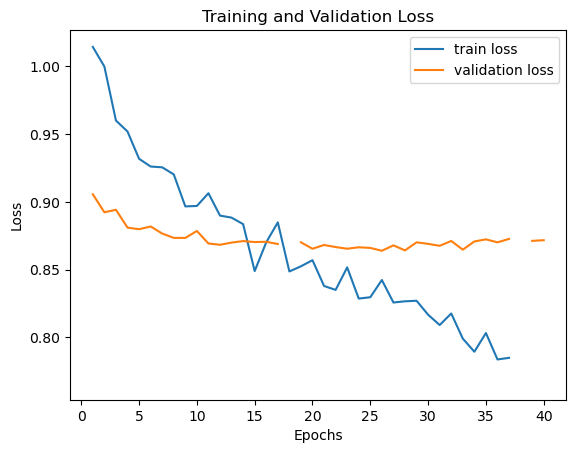

In [52]:
# plot the training loss and validation loss over the epochs
log_history = training_state['log_history']
train_loss = []
validation_loss = []

take = False
for log in log_history:
    epoch = log['epoch']
    if take:
        train_loss.append(log['loss'])
        take = False
    if int(epoch) == epoch:
        take = True
        validation_loss.append(log['eval_loss'])

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(np.arange(1, 40), train_loss, label='train loss')
ax.plot(np.arange(1, 41), validation_loss, label='validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
plt.show()

* best checkpoint

In [58]:
# best model checkpoint
best_checkpoint = training_state['best_model_checkpoint']
best_checkpoint

'lora/mT5_multilingual_XLSum/checkpoint-66900'

In [59]:
# load the model
model = AutoModelForSeq2SeqLM.from_pretrained(best_checkpoint).to(device)

In [60]:
# generate titles
generated_train_titles, generated_validation_titles, generated_test_titles = generate_titles(model, tokenizer)

100%|██████████| 1500/1500 [34:31<00:00,  1.38s/it]


In [63]:
# rouge score
avg_train_rouge_score, avg_validation_rouge_score = calculate_rouge(generated_train_titles, generated_validation_titles)
print('avg_train_rouge_score:', avg_train_rouge_score)
print('avg_validation_rouge_score:', avg_validation_rouge_score)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 2429.69it/s]

avg_train_rouge_score: 0.27600844987255696
avg_validation_rouge_score: 0.24057149192332275


In [64]:
# Store the generated summaries in the Kaggle-accepted format
submission_df = generate_submission_df(generated_test_titles)
submission_df.head()

,ID,titles
0,0,L'Assemblée nationale a voté mercredi le proje...
1,1,"""On a sacrifié une partie importante de la réf..."
2,2,Le quotidien La Dépêche révèle les dessous d'u...
3,3,Nicolas Lemonnier a décidé de se mettre à la c...
4,4,"Comme le révèle le Journal du Dimanche (JDD), ..."


In [65]:
# save the submission
submission_df.to_csv('../results/lora-mT5_multilingual_XLSum-checkpoint-66900.csv', index=False)

* checkpoint 50844

In [66]:
# checkpoint 50844
checkpoint = '50844'
save_path = f'lora/mT5_multilingual_XLSum/checkpoint-{checkpoint}'
# load the model
model = AutoModelForSeq2SeqLM.from_pretrained(save_path).to(device)

# generate titles
generated_train_titles, generated_validation_titles, generated_test_titles = generate_titles(model, tokenizer)

# rouge score
avg_train_rouge_score, avg_validation_rouge_score = calculate_rouge(generated_train_titles, generated_validation_titles)
print('avg_train_rouge_score:', avg_train_rouge_score)
print('avg_validation_rouge_score:', avg_validation_rouge_score)

100%|██████████| 200/200 [00:00<00:00, 2833.66it/s]

avg_train_rouge_score: 0.25660908736129256
avg_validation_rouge_score: 0.23247472084933193


In [68]:
# Store the generated summaries in the Kaggle-accepted format
submission_df = generate_submission_df(generated_test_titles)
print(submission_df.head())

# save the submission
submission_df.to_csv('../results/lora-mT5_multilingual_XLSum-checkpoint-50844.csv', index=False)

   ID                                             titles
0   0  L'examen en première lecture du projet de loi ...
1   1  Le maire de Pau dénonce un "manquement absolu"...
2   2  Un homme de 37 ans vivant à Aussonne, en Haute...
3   3  Nicolas Lemonnier a décidé de se mettre à la c...
4   4  Selon les informations du Journal du Dimanche ...


* checkpoint 96336

In [28]:
checkpoint = '96336'
save_path = f'lora/mT5_multilingual_XLSum/checkpoint-{checkpoint}'
# load the model
model = AutoModelForSeq2SeqLM.from_pretrained(save_path).to(device)

# generate titles
generated_train_titles, generated_validation_titles, generated_test_titles = generate_titles(model, tokenizer)

# rouge score
avg_train_rouge_score, avg_validation_rouge_score = calculate_rouge(generated_train_titles, generated_validation_titles)
print('avg_train_rouge_score:', avg_train_rouge_score)
print('avg_validation_rouge_score:', avg_validation_rouge_score)

100%|██████████| 200/200 [00:00<00:00, 2683.06it/s]

avg_train_rouge_score: 0.29680957652991713
avg_validation_rouge_score: 0.23852590293124376


In [29]:
# Store the generated summaries in the Kaggle-accepted format
submission_df = generate_submission_df(generated_test_titles)
print(submission_df.head())

# save the submission
submission_df.to_csv(f'../results/lora-mT5_multilingual_XLSum-checkpoint-{checkpoint}.csv', index=False)

   ID                                             titles
0   0  Les députés ont voté mercredi à l'Assemblée na...
1   1  Le président du MoDem a dénoncé un "manquement...
2   2  Le quotidien régional La Dépêche révèle les de...
3   3  Nicolas Lemonnier a décidé de se mettre à la c...
4   4  Selon les informations du Journal du Dimanche,...
